In [1]:
# -*- coding: utf-8 -*-
"""
Created on May 27, 2024
Last modified on May 27, 2024
@Author: Guan-Fu Liu

To test the read_results.py
"""
from read_results import *
import re
from matplotlib.gridspec import GridSpec
%matplotlib widget

In [2]:
# file_path = "./outputs/ChemEvo_galIMF_set.h5"
file_path = "./outputs/ChemEvo_N13.h5"
yield_files, groups, ElemNotice, dfs, ElemIntersect, SNIaOn, mass_lifeAge_file, mass_lifeAge, SFH, StarInitElement,\
             StellarMass, SNccNum, SNIaNum, AGB_Num, GasElement, ZGas, EjectElement, SNccElement, SNIaElement,\
             AGB_Element, YieldsTable, IMF_type, IMF_data, creation_Age, SFE, \
             interp_kind, comments, solar_set = read_results(file_path)

The elements you notice but not available in the yield table of SNIa, Z_0_02 are
 {'H', 'He'}
The yields from SNIa are taken into consideration in the result to be analysed.


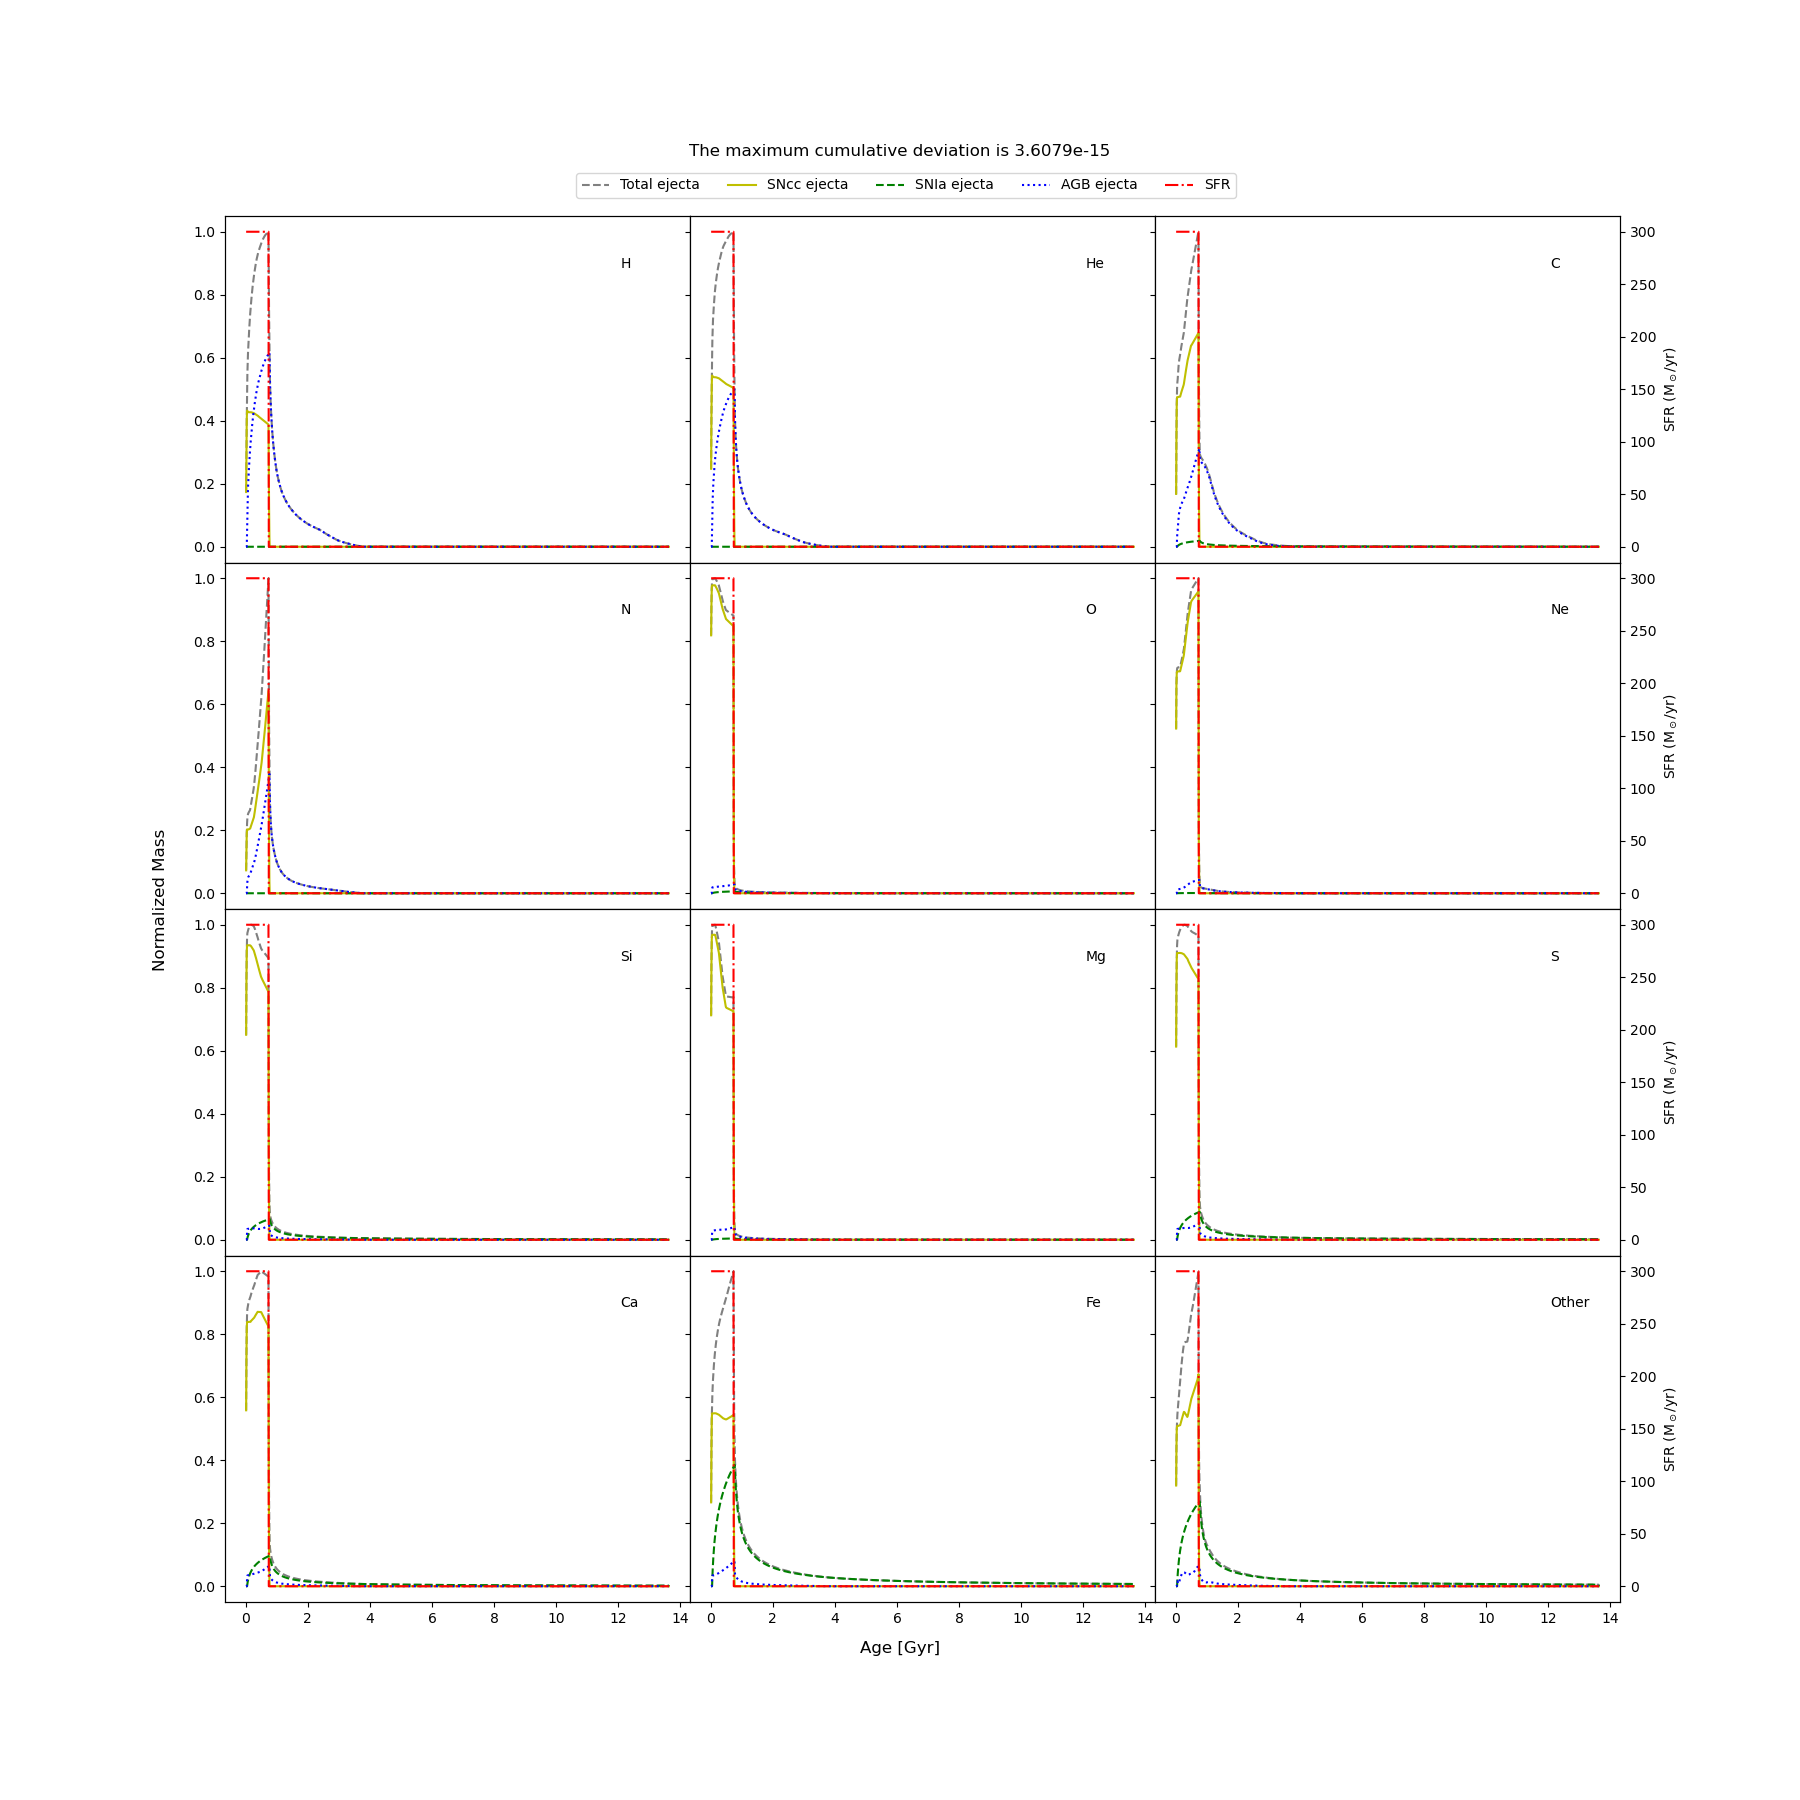

9.526959990452641e-16 3.607889209803182e-15


In [3]:
fig = plt.figure(figsize=(6*3, 4.5*4))
# fig.suptitle("Controlling subplot sizes with width_ratios and height_ratios")
gs = GridSpec(4, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1, 1], wspace=0.0, hspace=0.0)
axes = { }
for i, elem in enumerate(ElemNotice):
    axes[elem] = fig.add_subplot(gs[i//3, i%3])
    norm = EjectElement[:, constants.elem_names.index(elem)].max()
    line1, = axes[elem].plot(SFH['Age']/1e9, EjectElement[:, constants.elem_names.index(elem)]/norm,
                              '--', color='grey', markersize=4, label="Total ejecta")
    line2, = axes[elem].plot(SFH['Age']/1e9, SNccElement[:, constants.elem_names.index(elem)]/norm,
                              'y-', markersize=4, label="SNcc ejecta")
    line3, = axes[elem].plot(SFH['Age']/1e9, SNIaElement[:, constants.elem_names.index(elem)]/norm,
                              'g--', markersize=4, label="SNIa ejecta")
    line4, = axes[elem].plot(SFH['Age']/1e9, AGB_Element[:, constants.elem_names.index(elem)]/norm,
                              'b:', markersize=4, label="AGB ejecta")

    # axes[elem].set_xscale('log')
    # axes[elem].set_yscale('log')
    # axes[elem].set_xlim(1e-2, 13.8)
    # axes[elem].set_ylim(1e-5, 1.5)
    if i not in [9, 10, 11]:
        axes[elem].set_xticklabels([])
    if i not in [0, 3, 6, 9]:
        axes[elem].set_yticklabels([])
    axes[elem].annotate(elem, xy=(0.85, 0.85), xycoords='axes fraction')
    
    
    ax1 = axes[elem].twinx()
    line5, = ax1.plot(SFH['Age']/1e9, SFH['SFR'], 'r-.', label="SFR")
    if i in [2, 5, 8, 11]:
        ax1.set_ylabel(r"SFR (M$_\odot$/yr)")
    else:
        ax1.set_yticklabels([])

fig.supxlabel("Age [Gyr]", y=0.08)
fig.supylabel(r"Normalized Mass", x=0.085)
fig.legend((line1, line2, line3, line4, line5), ("Total ejecta", "SNcc ejecta", "SNIa ejecta", "AGB ejecta", "SFR"), loc=(0.32, 0.89), ncol=5)
deviation = np.abs(EjectElement.cumsum(axis=0)-SNccElement.cumsum(axis=0)-AGB_Element.cumsum(axis=0)-SNIaElement.cumsum(axis=0))
mask = EjectElement>0
deviation = deviation[mask]
deviation = deviation / EjectElement.cumsum(axis=0)[mask]
deviation = deviation.max()
fig.suptitle("The maximum cumulative deviation is %0.4e" % deviation, y=0.92)
# fig.suptitle("The evolution of the normalized instantaneous ejected mass", y=0.92)
fig.savefig("Instantaneous-ejecta-N13.pdf", dpi=300)
plt.show()
mask = EjectElement>0
print(np.abs((EjectElement-SNccElement-AGB_Element-SNIaElement)[mask]/EjectElement[mask]).max(), deviation)

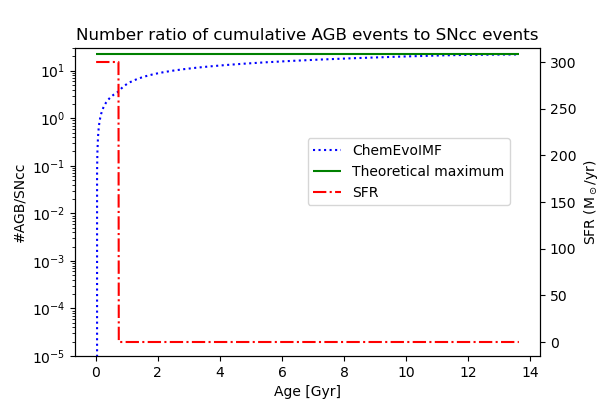

In [5]:
mask = SNccNum.cumsum()>0
imf = IMF(IMF_type=list(IMF_data.keys())[0]).imf
frac = quad(imf, constants.AGB_min, constants.AGB_max)[0] / quad(imf, constants.SNcc_min, constants.SNcc_max)[0]
fig, ax = plt.subplots(figsize=(6, 4))
line1, = ax.plot(SFH['Age'][mask]/1e9, AGB_Num.cumsum()[mask]/SNccNum.cumsum()[mask], 'b:', label="ChemEvoIMF")
line2 = ax.hlines(frac, SFH['Age'][0]/1e9, SFH['Age'][-1]/1e9, linestyles='-', color="green", label="Theoretical maximum")
ax1 = ax.twinx()
line3, = ax1.plot(SFH['Age']/1e9, SFH['SFR'], 'r-.', label="SFR")
ax1.set_ylabel(r"SFR (M$_\odot$/yr)")
ax.set_xlabel("Age [Gyr]")
ax.set_ylabel("#AGB/SNcc")
# ax.set_xscale("log")
# ax.set_xlim(0, 14)
ax.set_yscale("log")
ax.set_ylim(1e-5,30)
ax.legend((line1, line2, line3), ("ChemEvoIMF", "Theoretical maximum", "SFR"), loc=(0.5, 0.49), ncol=1)
ax.set_title("Number ratio of cumulative AGB events to SNcc events")
fig.savefig("AGB_Num2SNccNum.pdf")
plt.show()

In [6]:
AGB_Num.cumsum()

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       3.56964806e+10, 3.56977017e+10, 3.56977017e+10])

array([[b'AGB+SNcc: Z=0.0001, SNIa: Z=0.02',
        b'AGB+SNcc: Z=0.0001, SNIa: Z=0.02'],
       [b'AGB+SNcc: Z=0.0001, SNIa: Z=0.02',
        b'AGB+SNcc: Z=0.0001, SNIa: Z=0.02'],
       [b'AGB+SNcc: Z=0.0001, SNIa: Z=0.02',
        b'AGB+SNcc: Z=0.0003, SNIa: Z=0.02'],
       ...,
       [b'No Star Formation', b'No Star Formation'],
       [b'No Star Formation', b'No Star Formation'],
       [b'No Star Formation', b'No Star Formation']], dtype='|S32')

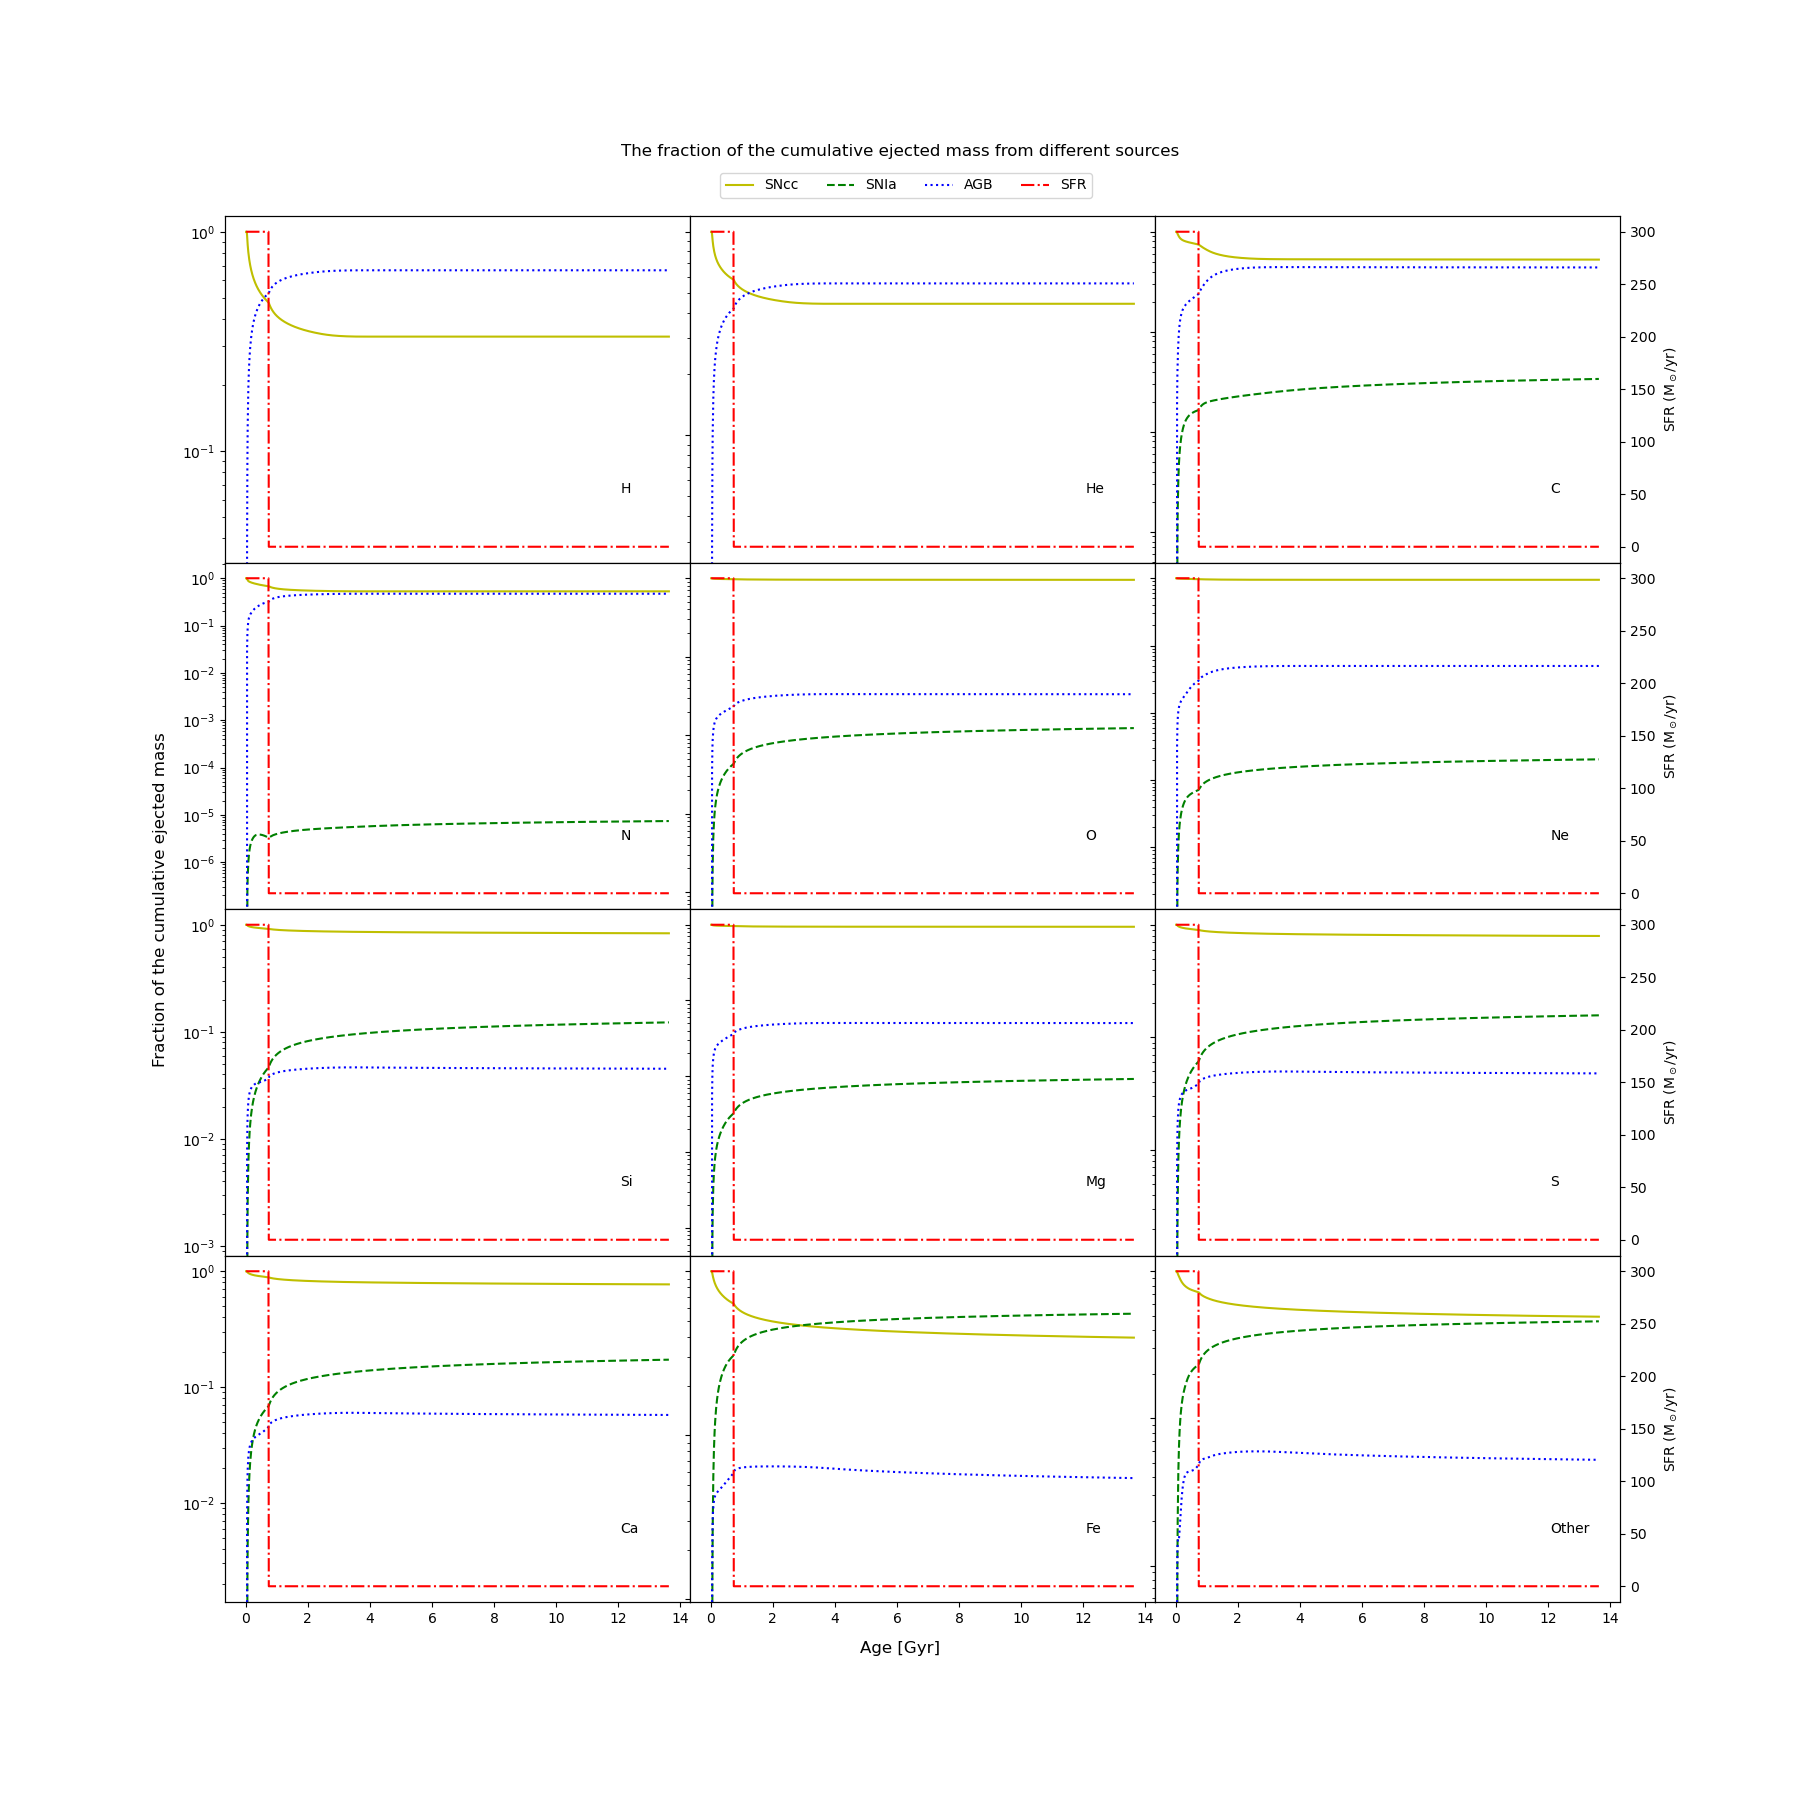

In [7]:
fig = plt.figure(figsize=(6*3, 4.5*4))
# fig.suptitle("Controlling subplot sizes with width_ratios and height_ratios")
gs = GridSpec(4, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1, 1], wspace=0.0, hspace=0.0)
for i, elem in enumerate(ElemNotice):
    ax = fig.add_subplot(gs[i])
    mask = EjectElement[:, constants.elem_names.index(elem)].cumsum()>0
    frac_SNIa = SNIaElement[:, constants.elem_names.index(elem)][mask].cumsum()\
                /EjectElement[:, constants.elem_names.index(elem)][mask].cumsum()
    frac_SNcc = SNccElement[:, constants.elem_names.index(elem)][mask].cumsum()\
                /EjectElement[:, constants.elem_names.index(elem)][mask].cumsum()
    frac_AGB = AGB_Element[:, constants.elem_names.index(elem)][mask].cumsum()\
                /EjectElement[:, constants.elem_names.index(elem)][mask].cumsum()

    line1, = ax.plot(SFH['Age'][mask]/1e9, frac_SNcc, 'y-', markersize=4, label="SNcc")
    line2, = ax.plot(SFH['Age'][mask]/1e9, frac_SNIa, 'g--', markersize=4, label="SNIa")
    line3, = ax.plot(SFH['Age'][mask]/1e9, frac_AGB, 'b:', markersize=4, label="AGB")

    ax1 = ax.twinx()
    line4, = ax1.plot(SFH['Age'][mask]/1e9, SFH['SFR'][mask], 'r-.', label="SFR")
    if i in [2, 5, 8, 11]:
        ax1.set_ylabel(r"SFR (M$_\odot$/yr)")
    else:
        ax1.set_yticklabels([])
    ax.annotate(elem, xy=(0.85, 0.2), xycoords='axes fraction')
    # ax.set_ylim(1e-5, 2)
    ax.set_yscale('log')
    if i not in [9, 10, 11]:
        ax.set_xticklabels([])
    if i not in [0, 3, 6, 9]:
        ax.set_yticklabels([])
fig.supxlabel("Age [Gyr]", y=0.08)
fig.supylabel("Fraction of the cumulative ejected mass", x=0.085)
fig.legend((line1, line2, line3, line4), ("SNcc", "SNIa", "AGB", "SFR"), loc=(0.40, 0.89), ncol=4)
fig.suptitle("The fraction of the cumulative ejected mass from different sources", y=0.92)
fig.savefig("Ejecta-fraction-N13.pdf", dpi=300)

In [8]:
frac_SNcc

array([1.        , 1.        , 1.        , ..., 0.49094041, 0.49092875,
       0.49092875])

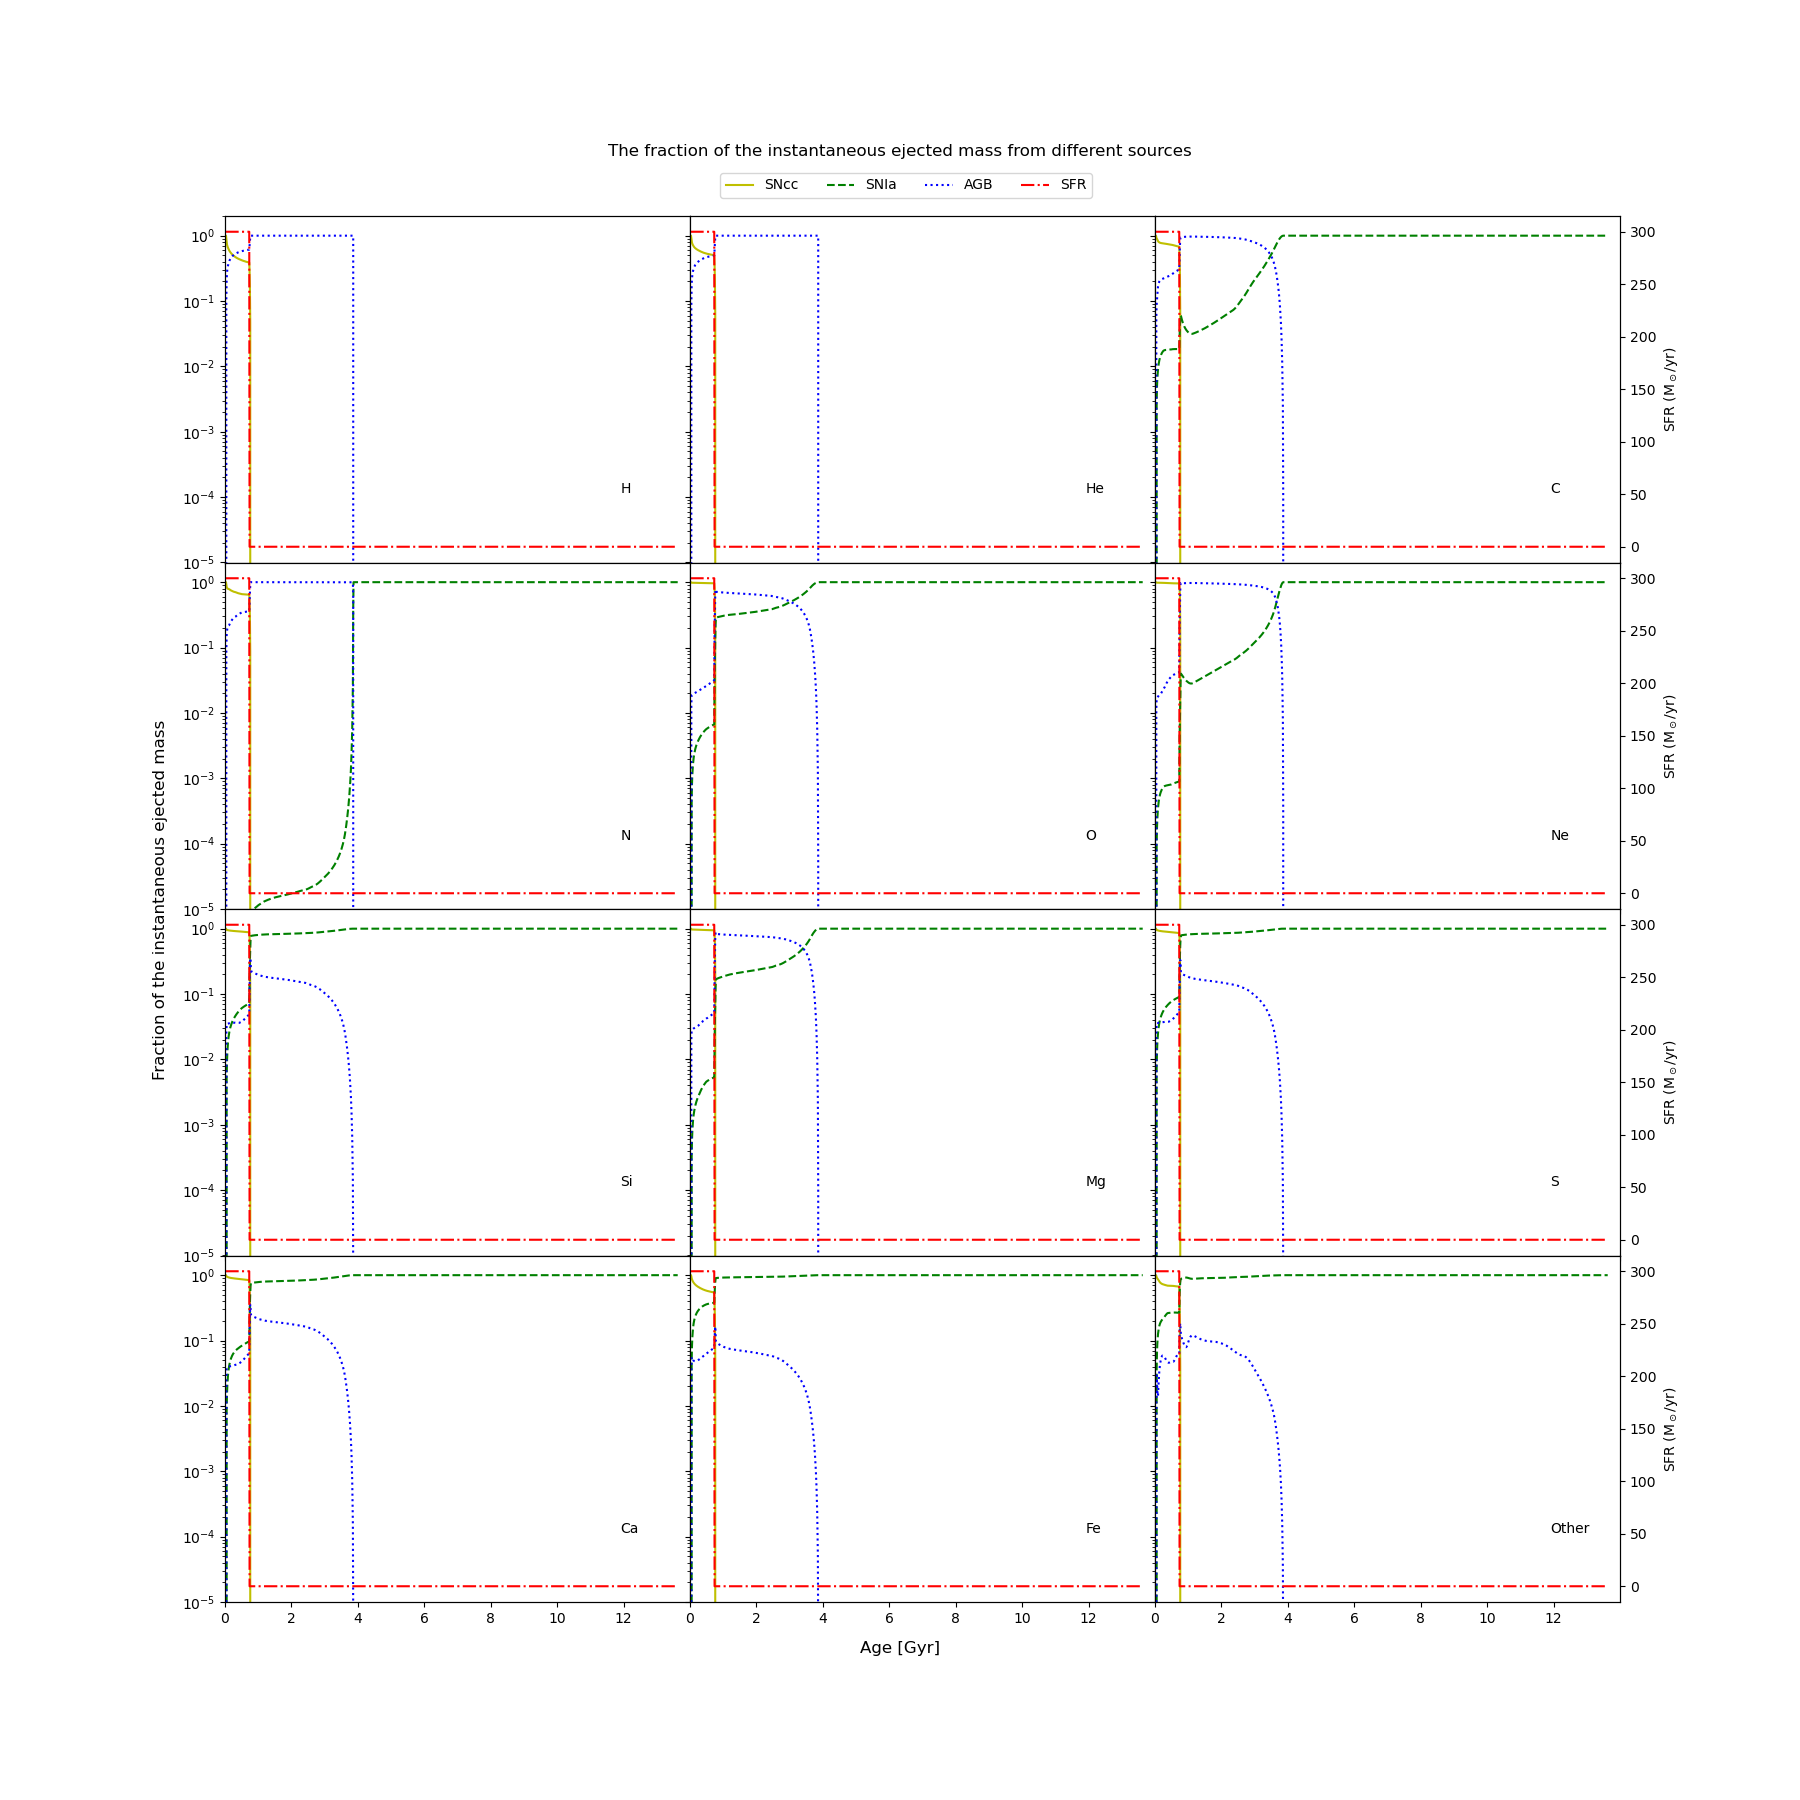

In [9]:
fig = plt.figure(figsize=(6*3, 4.5*4))
# fig.suptitle("Controlling subplot sizes with width_ratios and height_ratios")
gs = GridSpec(4, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1, 1], wspace=0.0, hspace=0.0)
for i, elem in enumerate(ElemNotice):
    ax = fig.add_subplot(gs[i])
    frac_SNIa = np.array([SNIaElement[i, constants.elem_names.index(elem)]/\
                          EjectElement[i, constants.elem_names.index(elem)] \
                          if EjectElement[i, constants.elem_names.index(elem)]>0 else 0 for i in range(len(SFH['Age'])-1)])
    frac_SNcc = np.array([SNccElement[i, constants.elem_names.index(elem)]/\
                          EjectElement[i, constants.elem_names.index(elem)] \
                          if EjectElement[i, constants.elem_names.index(elem)]>0 else 0 for i in range(len(SFH['Age'])-1)])
    frac_AGB = np.array([AGB_Element[i, constants.elem_names.index(elem)]/\
                            EjectElement[i, constants.elem_names.index(elem)] \
                            if EjectElement[i, constants.elem_names.index(elem)]>0 else 0 for i in range(len(SFH['Age'])-1)])
    line1, = ax.plot(SFH['Age'][:-1]/1e9, frac_SNcc, 'y-', markersize=4, label="SNcc")
    line2, = ax.plot(SFH['Age'][:-1]/1e9, frac_SNIa, 'g--', markersize=4, label="SNIa")
    line3, = ax.plot(SFH['Age'][:-1]/1e9, frac_AGB, 'b:', markersize=4, label="AGB")
    ax.annotate(elem, xy=(0.85, 0.2), xycoords='axes fraction')
    ax.set_ylim(1e-5, 2)
    ax.set_yscale('log')
    if i not in [9, 10, 11]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks([0, 2, 4, 6, 8, 10, 12])
    if i not in [0, 3, 6, 9]:
        ax.set_yticklabels([])
    ax.set_xlim(0, 14)
    ax1 = ax.twinx()
    line4, = ax1.plot(SFH['Age']/1e9, SFH['SFR'], 'r-.', label="SFR")
    if i in [2, 5, 8, 11]:
        ax1.set_ylabel(r"SFR (M$_\odot$/yr)")
    else:
        ax1.set_yticklabels([])

fig.supxlabel("Age [Gyr]", y=0.08)
fig.supylabel("Fraction of the instantaneous ejected mass", x=0.085)
fig.legend((line1, line2, line3, line4), ("SNcc", "SNIa", "AGB", "SFR"), loc=(0.40, 0.89), ncol=4)
fig.suptitle("The fraction of the instantaneous ejected mass from different sources", y=0.92)
fig.savefig("Instantaneous-ejecta-fraction-N13.pdf", dpi=300)

In [10]:
elem = "Fe"
frac_AGB = np.array([AGB_Element[i, constants.elem_names.index(elem)]/\
                            EjectElement[i, constants.elem_names.index(elem)] \
                            if EjectElement[i, constants.elem_names.index(elem)]>0 else 0 for i in range(len(SFH['Age'])-1)])

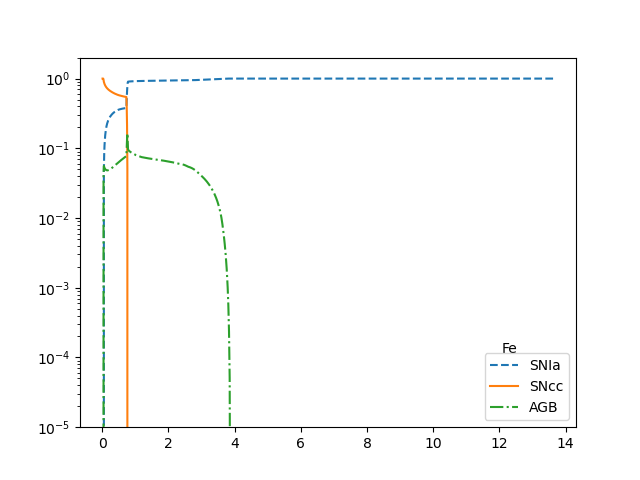

In [11]:
fig, ax = plt.subplots()


elem = "Fe"
frac_SNIa = np.array([SNIaElement[i, constants.elem_names.index(elem)]/\
                        EjectElement[i, constants.elem_names.index(elem)] \
                        if EjectElement[i, constants.elem_names.index(elem)]>0 else 0 for i in range(len(SFH['Age'])-1)])
frac_SNcc = np.array([SNccElement[i, constants.elem_names.index(elem)]/\
                        EjectElement[i, constants.elem_names.index(elem)] \
                        if EjectElement[i, constants.elem_names.index(elem)]>0 else 0 for i in range(len(SFH['Age'])-1)])
frac_AGB = np.array([AGB_Element[i, constants.elem_names.index(elem)]/\
                        EjectElement[i, constants.elem_names.index(elem)] \
                        if EjectElement[i, constants.elem_names.index(elem)]>0 else 0 for i in range(len(SFH['Age'])-1)])


line1, = ax.plot(SFH['Age'][:-1]/1e9, frac_SNIa, '--', markersize=4, label="SNIa")
line2, = ax.plot(SFH['Age'][:-1]/1e9, frac_SNcc, '-', markersize=4, label="SNcc")
line3, = ax.plot(SFH['Age'][:-1]/1e9, frac_AGB, '-.', markersize=4, label="AGB")
ax.annotate(elem, xy=(0.85, 0.2), xycoords='axes fraction')
ax.set_ylim(1e-5, 2)
ax.set_yscale('log')
ax.legend()

In [12]:
2.95+0.73

3.68

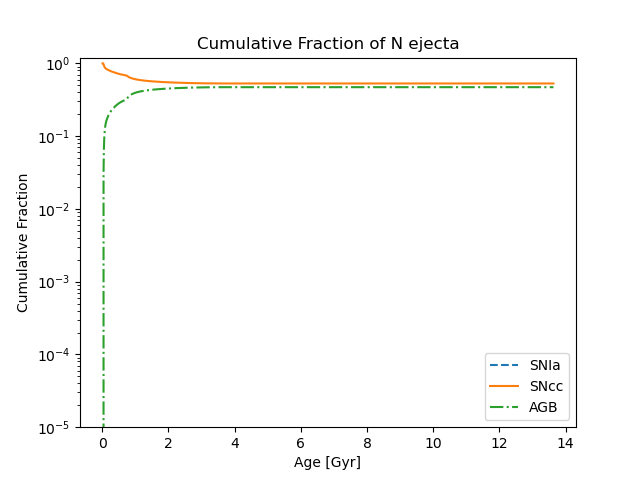

In [13]:
elem = "N"
mask = EjectElement[:, constants.elem_names.index(elem)]>0
frac_SNIa = SNIaElement[:, constants.elem_names.index(elem)][mask].cumsum()/\
            EjectElement[:, constants.elem_names.index(elem)][mask].cumsum()
frac_SNcc = SNccElement[:, constants.elem_names.index(elem)][mask].cumsum()/\
            EjectElement[:, constants.elem_names.index(elem)][mask].cumsum()
frac_AGB = AGB_Element[:, constants.elem_names.index(elem)][mask].cumsum()/\
            EjectElement[:, constants.elem_names.index(elem)][mask].cumsum()
fig, ax = plt.subplots()
ax.plot(SFH['Age'][mask]/1e9, frac_SNIa, '--', label="SNIa")
ax.plot(SFH['Age'][mask]/1e9, frac_SNcc, '-', label="SNcc")
ax.plot(SFH['Age'][mask]/1e9, frac_AGB, '-.', label="AGB")
ax.set_ylim(1e-5, 1.2)
ax.set_yscale('log')
ax.legend()
ax.set_xlabel("Age [Gyr]")
ax.set_ylabel("Cumulative Fraction")
ax.set_title("Cumulative Fraction of %s ejecta"%elem)
plt.show()

Text(0.5, 0, 'Age [Gyr]')

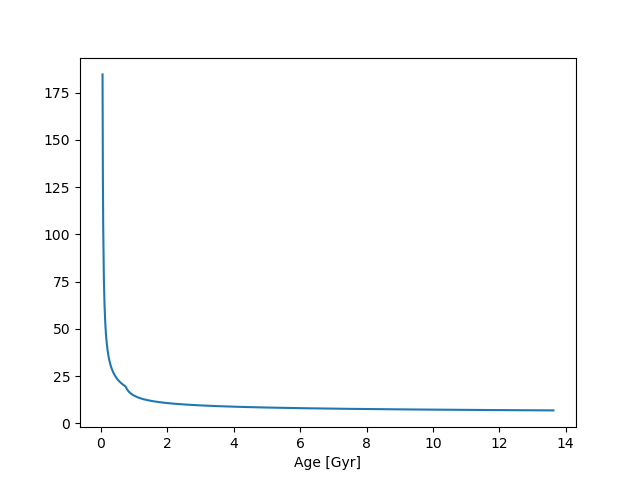

In [14]:
mask = SNIaNum > 0
frac_SNcc = SNccNum[mask].cumsum()/SNIaNum[mask].cumsum()
fig, ax = plt.subplots()
ax.plot(SFH['Age'][mask]/1e9, frac_SNcc, '-')
# ax.set_ylim(0, 1.1)
ax.set_xlabel("Age [Gyr]")

In [15]:
mask = (SNIaElement[:, constants.elem_names.index("Fe")] > 0) | (SNccElement[:, constants.elem_names.index("Fe")] > 0)
SNIaElement[mask, constants.elem_names.index("Fe")].cumsum()/(SNIaElement[mask, constants.elem_names.index("Fe")].cumsum()+
                                                              SNccElement[mask, constants.elem_names.index("Fe")].cumsum())

array([0.        , 0.        , 0.        , ..., 0.58310513, 0.58313674,
       0.58314938])

In [16]:
p_denominator=4.819420e-04
p_numerator=1.575560e-04
p_preset = p_numerator/p_denominator
quad(lambda m: m**(-2.35), 8, 150)[0]/quad(lambda m: m**(-2.35), 1.5, 8)[0]/p_preset

0.3496204059670645

In [17]:
SNIaElement[:, constants.elem_names.index("Fe")].sum()/\
(SNccElement[:, constants.elem_names.index("Fe")].sum() + SNIaElement[:, constants.elem_names.index("Fe")].sum())

0.5831493772010172

In [18]:
SNccNum.sum()/SNIaNum.sum()

7.1177540195435745

In [19]:
EjectElement[:, constants.elem_names.index(elem)]

array([5.31838349e+04, 1.00024886e+05, 1.39311299e+05, ...,
       3.44808998e-02, 1.37850758e-02, 0.00000000e+00])

In [20]:
SNIaElement[:, constants.elem_names.index(elem)]

array([0.        , 0.        , 0.        , ..., 0.0344809 , 0.01378508,
       0.        ])

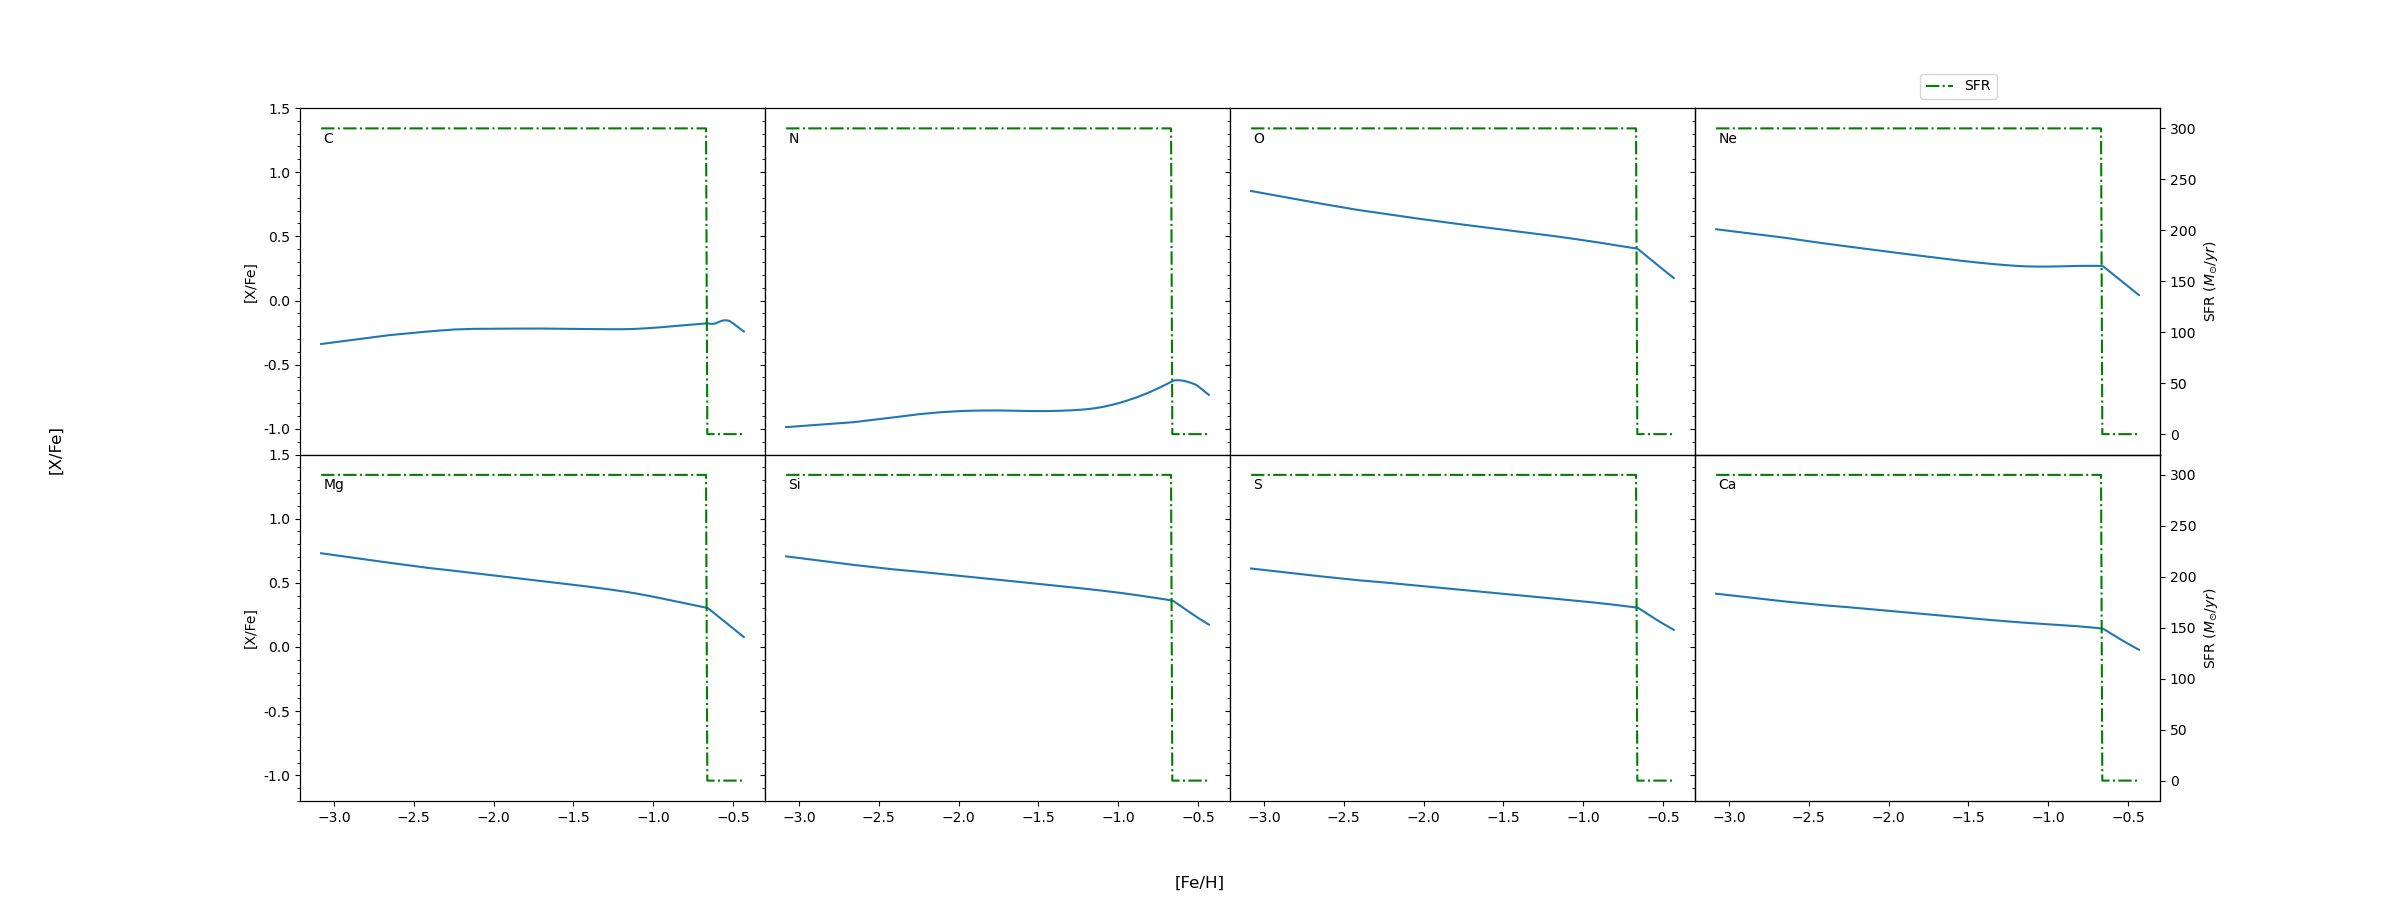

In [21]:
Zi2Zj = { }
Zi2Zj.update(GetZi2Zj(GasElement, "Fe", "H", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "C", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "N", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "O", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "Ne", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "Mg", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "Si", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "S", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "Ca", "Fe", solar_set, fill_value=None))

fig = plt.figure(figsize=(6*4, 4.5*2))
gs = GridSpec(2, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1], wspace=0, hspace=0)
axes = { }
axes['1'] = fig.add_subplot(gs[0])
axes['2'] = fig.add_subplot(gs[1])
axes['3'] = fig.add_subplot(gs[2])
axes['4'] = fig.add_subplot(gs[3])
axes['5'] = fig.add_subplot(gs[4])
axes['6'] = fig.add_subplot(gs[5])
axes['7'] = fig.add_subplot(gs[6])
axes['8'] = fig.add_subplot(gs[7])

Zi_list = ['C', 'N', 'O', 'Ne', 'Mg', 'Si', 'S', 'Ca']

for i, elem in enumerate(Zi_list):
    ax = axes["%d"%(Zi_list.index(elem)+1)]
    ax.plot(Zi2Zj["[Fe/H]"], Zi2Zj["[%s/Fe]"%elem], '-')
    ax.annotate(elem, xy=(0.05, 0.9), xycoords='axes fraction')
    ax.set_ylim(-1.2, 1.5)
    minor_yticks = np.arange(-1.2, 1.5, 0.1)
    ax.set_yticklabels([])
    ax.set_yticks(minor_yticks, minor=True)
    ax1 = ax.twinx()
    ax1.set_ylim(-20,320)
    line1 = ax1.plot(Zi2Zj["[Fe/H]"], SFH['SFR'][Zi2Zj['Fe/H-mask']], 'g-.')
    ax1.set_yticks([])

major_yticks = np.arange(-1, 1.5+0.5, 0.5)
axes["1"].set_ylabel("[X/Fe]")
axes["1"].set_yticks(major_yticks)
axes["1"].set_yticklabels(major_yticks)
axes["5"].set_ylabel("[X/Fe]")
axes["5"].set_yticks(major_yticks)
axes["5"].set_yticklabels(major_yticks)
major_twin_yticks = np.arange(0, 300+50, 50)
ax1 = axes["4"].twinx()
ax1.set_ylabel(r"SFR ($M_{\odot}/yr$)")
ax1.set_ylim(-20,320)
ax1.set_yticks(major_twin_yticks)
ax1.set_yticklabels(major_twin_yticks)
ax1 = axes["8"].twinx()
ax1.set_ylabel(r"SFR ($M_{\odot}/yr$)")
ax1.set_ylim(-20,320)
ax1.set_yticks(major_twin_yticks)
ax1.set_yticklabels(major_twin_yticks)

fig.legend(line1, ['SFR'], loc=[0.8, 0.89])
fig.supylabel('[X/Fe]')
fig.supxlabel('[Fe/H]')
fig.savefig("ChemEvoIMF_N13.pdf", dpi=300)
plt.show()

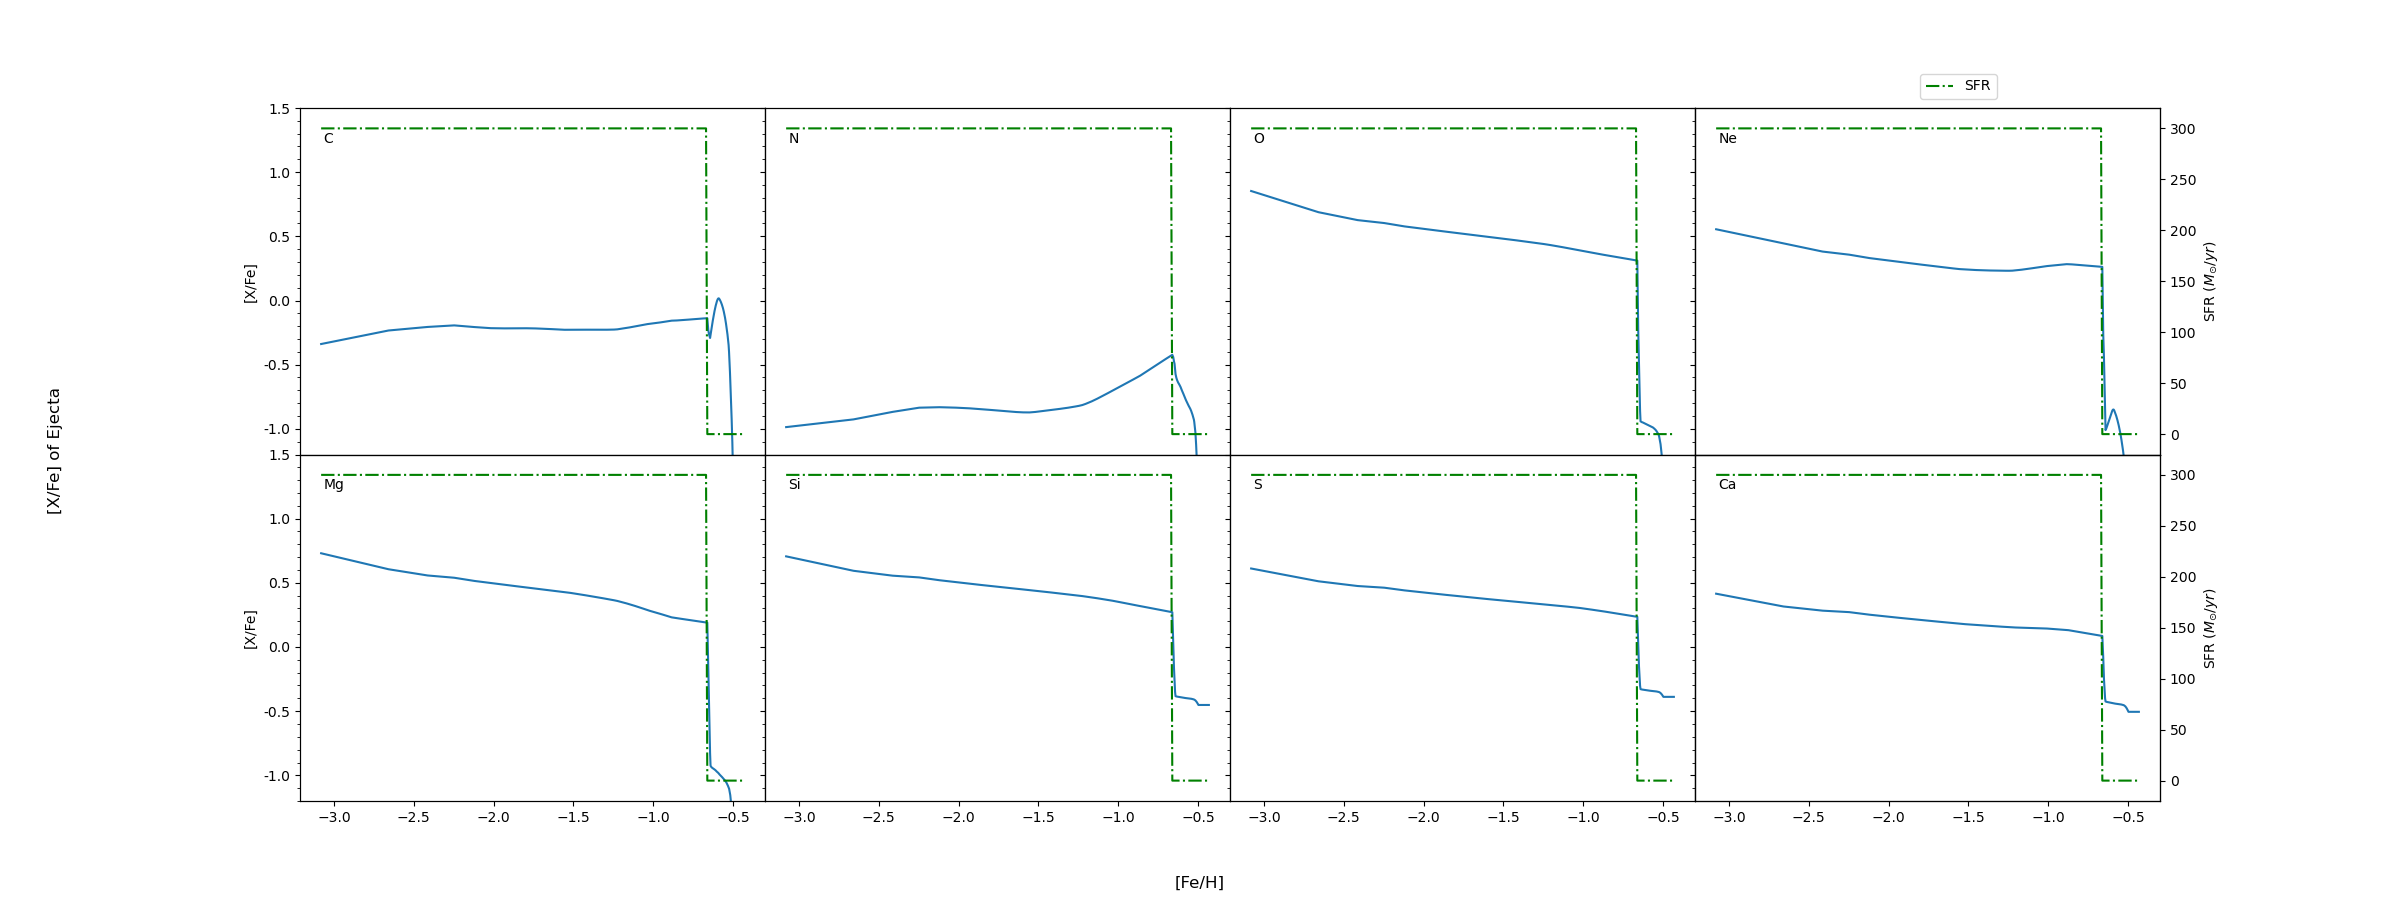

In [22]:
Zi2Zj_e = { }
Zi2Zj_e.update(GetZi2Zj(EjectElement, "Fe", "H", solar_set, fill_value=None))
Zi2Zj_e.update(GetZi2Zj(EjectElement, "C", "Fe", solar_set, fill_value=None))
Zi2Zj_e.update(GetZi2Zj(EjectElement, "N", "Fe", solar_set, fill_value=None))
Zi2Zj_e.update(GetZi2Zj(EjectElement, "O", "Fe", solar_set, fill_value=None))
Zi2Zj_e.update(GetZi2Zj(EjectElement, "Ne", "Fe", solar_set, fill_value=None))
Zi2Zj_e.update(GetZi2Zj(EjectElement, "Mg", "Fe", solar_set, fill_value=None))
Zi2Zj_e.update(GetZi2Zj(EjectElement, "Si", "Fe", solar_set, fill_value=None))
Zi2Zj_e.update(GetZi2Zj(EjectElement, "S", "Fe", solar_set, fill_value=None))
Zi2Zj_e.update(GetZi2Zj(EjectElement, "Ca", "Fe", solar_set, fill_value=None))

fig = plt.figure(figsize=(6*4, 4.5*2))
gs = GridSpec(2, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1], wspace=0, hspace=0)
axes = { }
axes['1'] = fig.add_subplot(gs[0])
axes['2'] = fig.add_subplot(gs[1])
axes['3'] = fig.add_subplot(gs[2])
axes['4'] = fig.add_subplot(gs[3])
axes['5'] = fig.add_subplot(gs[4])
axes['6'] = fig.add_subplot(gs[5])
axes['7'] = fig.add_subplot(gs[6])
axes['8'] = fig.add_subplot(gs[7])

Zi_list = ['C', 'N', 'O', 'Ne', 'Mg', 'Si', 'S', 'Ca']

for i, elem in enumerate(Zi_list):
    ax = axes["%d"%(Zi_list.index(elem)+1)]
    ax.plot(Zi2Zj["[Fe/H]"], Zi2Zj_e["[%s/Fe]"%elem], '-')
    ax.annotate(elem, xy=(0.05, 0.9), xycoords='axes fraction')
    ax.set_ylim(-1.2, 1.5)
    minor_yticks = np.arange(-1.2, 1.5, 0.1)
    ax.set_yticklabels([])
    ax.set_yticks(minor_yticks, minor=True)
    ax1 = ax.twinx()
    ax1.set_ylim(-20,320)
    line1 = ax1.plot(Zi2Zj["[Fe/H]"], SFH['SFR'][Zi2Zj['Fe/H-mask']], 'g-.')
    ax1.set_yticks([])

major_yticks = np.arange(-1, 1.5+0.5, 0.5)
axes["1"].set_ylabel("[X/Fe]")
axes["1"].set_yticks(major_yticks)
axes["1"].set_yticklabels(major_yticks)
axes["5"].set_ylabel("[X/Fe]")
axes["5"].set_yticks(major_yticks)
axes["5"].set_yticklabels(major_yticks)
major_twin_yticks = np.arange(0, 300+50, 50)
ax1 = axes["4"].twinx()
ax1.set_ylabel(r"SFR ($M_{\odot}/yr$)")
ax1.set_ylim(-20,320)
ax1.set_yticks(major_twin_yticks)
ax1.set_yticklabels(major_twin_yticks)
ax1 = axes["8"].twinx()
ax1.set_ylabel(r"SFR ($M_{\odot}/yr$)")
ax1.set_ylim(-20,320)
ax1.set_yticks(major_twin_yticks)
ax1.set_yticklabels(major_twin_yticks)

fig.legend(line1, ['SFR'], loc=[0.8, 0.89])
fig.supylabel('[X/Fe] of Ejecta')
fig.supxlabel('[Fe/H]')
fig.savefig("ChemEvoIMF_Ejecta_N13.pdf", dpi=300)
plt.show()

In [23]:
a = np.array([9,8,7,6,5,4])
a.argsort()

array([5, 4, 3, 2, 1, 0])